In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import re

from sklearn.ensemble import IsolationForest


###########################################
#               FUNCTIONS                 #
###########################################


def clean_reference(ref,outliers):
    for i in outliers:
        ref = ref.drop(labels=i,axis=1)

    return ref

def norm_ref(ref):
    med = ref.median(axis=0)
    norm_ref = ref/med
    return norm_ref, med

def create_synthetic(norm_ref,med,N):
    synt = pd.DataFrame(index=norm_ref.index,columns=range(N))
    for j in range(N):
        for i in norm_ref.index:
            synt[j][i] = np.random.choice(norm_ref.loc[norm_ref.index==i].values.flatten())

        synt[j] = synt[j] * np.random.choice(med)
    synt.columns = ["sample_" + str(i) for i in range(synt.shape[1])]
    return synt

def add_features(synt,sample,gene,factor,exon=None):
    if exon is None:
        pattern = gene
        tmp = [str(synt.index[i]).split("_")[0] for i in range(synt.shape[0])]
        synt.loc[[tmp[i]==pattern for i in range(len(tmp))],sample] = synt.loc[[tmp[i]==pattern for i in range(len(tmp))]][sample] * factor
        
    if exon is not None:
        pattern = gene + "_" + exon
        tmp = [str(synt.index[i]).split("_")[0] + "_" + str(synt.index[i]).split("_")[1] for i in range(synt.shape[0])] 
        synt.loc[[tmp[i]==pattern for i in range(len(tmp))],sample] = synt.loc[[tmp[i]==pattern for i in range(len(tmp))]][sample] * factor
    
    res = synt
    return res


def openJson(path,n):
    """
    Opens json files in path to create a reads matrix
    """
    tmp = os.listdir(path)
    tmp = np.array(tmp)[np.array([bool(re.findall("depths.json$",tmp[i])) for i in range(len(tmp))])]
    reads = np.zeros((n,len(tmp)))
    amplicons = ["" for x in range(n)]
    q=0
    for p in tmp:
        with open(path+p) as json_file:
            data = json.load(json_file)
            for i in range(n):
                amplicons[i] = data[i]['name']
                for j in data[i]['depths']:
                    reads[i,q] = int(data[i]['depths'][j]['min'])
        q=q+1
    reads = pd.DataFrame(data = reads,index=amplicons)
    reads.columns = [i.split('_')[0]+'_'+i.split('_')[1] for i in tmp]
    return reads

def sumLibraries(reads):
    samples = np.unique([i.split('_')[0] for i in reads.columns])
    reads_f = np.zeros((reads.shape[0],len(samples)))
    q=0
    for i in samples:
        sub = reads.filter(regex="^"+i)
        reads_f[:,q] = sub.sum(axis=1)
        q=q+1
    reads_f = pd.DataFrame(data = reads_f,index=reads.index)
    reads_f.columns = list(samples)
    return(reads_f)

def correctIndex(reads,correspondance):
    l = ["" for x in range(len(reads.index))]
    q=0
    for i in reads.index:
        l[q] = i[(len(i)-9):len(i)]
        q=q+1
    final = reads[[correspondance["amplicon"][0] in l[x] for x in range(len(l))]]
    for i in correspondance["amplicon"]:
        if i!=correspondance["amplicon"][0]:
            final = pd.concat([final,reads[[i in l[x] for x in range(len(l))]]])
    final.index = correspondance["gene_exon"] + "_" + correspondance["amplicon"]
    return final


def filterReads(reads,N,output_path):
    reads = reads.loc[:,reads.sum(axis=0)>N]
    reads = reads.filter(regex="^(?!MSI)",axis=0)
    reads = reads.filter(regex="^(?!TN)")
    reads = reads.filter(regex="^(?!TP)")
    reads = reads.filter(regex="^(?!HD)")
    reads = reads.filter(regex="^(?!H2)")
    reads.to_csv(output_path, sep="\t",index=True)
    return(reads)


def normalizeReads(reads,output_path,save=False):
    reads_norm=reads/reads.median(axis=0)
    reads = np.log(reads+1)
    if save==True:
        reads_norm.to_csv(output_path, sep="\t",index=True)
    return(reads_norm)


def aberrantSamples(reads):
    read = reads.astype("float")
    tmp = np.percentile(reads, 99, axis = 0)/np.mean(reads, axis = 0)
    random_data = np.array(tmp).reshape(-1,1)

    clf = IsolationForest(contamination=0.1).fit(random_data)
    preds = clf.predict(random_data)
    res = np.array(reads.columns)[preds==-1]
    return(res)

def aberrantSamples2(reads):
    read = reads.astype("float")
    tmp = np.percentile(reads, 5, axis = 0)/np.mean(reads, axis = 0)
    random_data = np.array(tmp).reshape(-1,1)

    clf = IsolationForest(contamination=0.1).fit(random_data)
    preds = clf.predict(random_data)
    res = np.array(reads.columns)[preds==-1]
    return(res)


def aberrantAmplicons(reads_norm,abSamples):
    for name in res:
        random_data = np.array(reads_norm[name]).reshape(-1,1)
        clf = IsolationForest(contamination=0.001).fit(np.array(np.mean(reads_norm, axis = 1)).reshape(-1,1))
        preds = clf.predict(random_data)
        print(name)
        print(np.array(reads_norm.index)[preds==-1])

def aberrantAmpliconsPerSample(name,reads_norm,verbose=False):
    random_data = np.array(reads_norm[name]).reshape(-1,1)
    clf = IsolationForest(contamination=0.01).fit(np.array(np.mean(reads_norm, axis = 1)).reshape(-1,1))
    preds = clf.predict(random_data)
    if verbose:
        print(name)
        print(np.array(reads_norm.index)[preds==-1])
    return(np.array(reads_norm.index)[preds==-1])


def aberrantAmpliconsPerSample2(name,reads,abSamples,verbose=False):
    ab = [i in abSamples for i in reads.columns]
    normalReads = reads[np.delete(reads.columns,ab)]
    med = np.percentile(normalReads, 99, axis = 1)
    reads = (reads.T/med).T
    random_data = np.array(reads[name]).reshape(-1,1)
    clf = IsolationForest(contamination=0.05).fit(np.array(np.median(reads, axis = 1)).reshape(-1,1))
    preds = clf.predict(random_data)
    if verbose:
        print(name)
        print(np.array(reads.index)[preds==-1])
    return(np.array(reads.index)[preds==-1])



def percentagePerExon(amplified,reads,verbose=False):
    genes = [i.split('_')[0] for i in reads.index]
    exons = [i.split('_')[1] for i in reads.index]
    g_e = [genes[i]+'_'+exons[i] for i in range(len(genes))]
    n_ge = np.array([g_e.count(i) for i in np.unique(g_e)])
    ag = [i.split('_')[0] for i in amplified]
    ae = [i.split('_')[1] for i in amplified]
    age = [ag[i]+'_'+ae[i] for i in range(len(amplified))]
    f = pd.DataFrame(index=np.unique(age),columns=["percentage"])
    f = f.fillna(0)
    for i in range(len(np.unique(age))):
        f['percentage'][i] = 100*float(age.count(''.join(np.unique(age)[i]))/n_ge[np.unique(g_e)==''.join(np.unique(age)[i])])
        if verbose:
            if f['percentage'][i]>50:
                print(np.unique(age)[i] + ": " + str(round(f['percentage'][i]))+'%'+' des amplicons de l\'exon sont aberrants')
    return(f)

def percentagePerGene(amplified,reads,verbose=False):
    genes = [i.split('_')[0] for i in reads.index]
    ag = [i.split('_')[0] for i in amplified]
    n_g = np.array([genes.count(i) for i in np.unique(genes)])
    f = pd.DataFrame(index=np.unique(ag),columns=["percentage"])
    f = f.fillna(0)
    for i in range(len(np.unique(ag))):
        f['percentage'][i] = 100*float(ag.count(''.join(np.unique(ag)[i]))/n_g[np.unique(genes)==''.join(np.unique(ag)[i])])
        if verbose:
            if f['percentage'][i]>50:
                print(np.unique(ag)[i] + ": " + str(round(f['percentage'][i]))+'%'+' des amplicons du gene sont aberrants')
    return(f)

def amplifEvalGene(reads,abSamples,gene,sample):
    reads_m = reads/reads.median(axis=0)
    sub = reads_m
    for i in abSamples:
        sub = sub.drop(labels=i,axis=1)
    reads_m = reads_m.filter(regex="^"+gene,axis=0)
    reads_m = reads_m[sample]   
    val = np.mean(reads_m)/np.mean(sub.mean())
    if val==np.inf:
        val = 100
    return val

def scoreAmplif(k,n,N,mu):
    p = n/N
    x = np.log(1/((p**k)*(1-p)**(n-k)))*(k/n)
    # score = 1/(1+np.exp(-x))
    score = x/390 + 190/390
    
    return x

def aberrantAmpliconsFinal(reads, reads_norm, abSamples,abSamples2,run,threshold):
    f = pd.DataFrame(columns=["run","name","gene","amplif","score"])
        
    q=0 
    for name in abSamples2:
        #abAmp = aberrantAmpliconsPerSample2(name,reads_norm,abSamples,verbose=False)
        abAmp = aberrantAmpliconsPerSample(name,reads_norm,verbose=False)
        if abAmp.shape!=(0,):
            genes = np.unique([i.split('_')[0] for i in abAmp])
            for gene in genes:
                r = re.compile(gene)
                abEx = list(filter(r.match, abAmp))
                exons1 = [i.split('_')[0]+"_"+i.split('_')[1] for i in abEx]
                tmp = reads.filter(regex="^"+gene,axis=0)
                exons2 = [i.split('_')[0]+"_"+i.split('_')[1] for i in tmp.index]
                
                score = scoreAmplif(len(abEx),tmp.shape[0],reads.shape[0],len(abEx)/tmp.shape[0])
                
                amplif = amplifEvalGene(reads, abSamples, gene, name)

                if score>threshold:
                    if amplif>1:
                        f.loc[q] = [run,name,gene,amplif,score]
                        q=q+1
                    if amplif<1:
                        f.loc[q] = [run,name,gene,amplif,score]
                        q=q+1

    return(f)





In [32]:
from tqdm.notebook import tqdm
pd.set_option('display.max_rows', 100)

run = "synt_tsca"
output_path = "/Users/admin/Documents/CNV/"

synt = pd.read_csv("/Users/admin/Documents/CNV/synthetic_raw.tsv",sep="\t",index_col=0)

factor = 3
data = add_features(synt,sample="sample_1",gene = "PDGFRA",factor = factor)
data = add_features(data,sample="sample_1",gene = "KIT",factor = factor)
data = add_features(data,sample="sample_10",gene = "KRAS",factor = factor)
data = add_features(data,sample="sample_15",gene = "KRAS",factor = factor)

abSamples = aberrantSamples(data)
#abSamples = ["sample_1","sample_10","sample_15"]
print(abSamples)
final_norm = normalizeReads(data,output_path+'/reads_'+run+'_norm2.tsv',save=False)
ff = aberrantAmpliconsFinal(data,final_norm,abSamples,data.columns,run,3)
ff


['sample_1' 'sample_9' 'sample_17' 'sample_29']


,run,name,gene,amplif,score
0,synt_tsca,sample_1,KIT,4.102158,40.224572
1,synt_tsca,sample_1,PDGFRA,3.997120,25.165178
2,synt_tsca,sample_15,KRAS,3.543463,10.444820


['sample_0', 'sample_19', 'sample_28', 'sample_20']
            0
0    sample_0
6    sample_6
7    sample_7
9    sample_9
15  sample_15
17  sample_17
19  sample_19
20  sample_20
21  sample_21
28  sample_28
29  sample_29


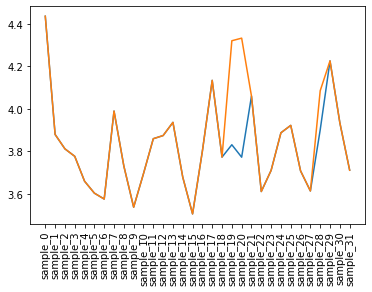

In [21]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

n = 0
factor = 3
gene = "EGFR"

tp=[]
fp=[]

synt = pd.read_csv("/Users/admin/Documents/CNV/synthetic_raw.tsv",sep="\t",index_col=0)
reads = add_features(synt,sample="sample_0",gene = gene,factor = factor)
temp = ["sample_0"]

tmp = np.percentile(reads, 99, axis = 0)/np.mean(reads, axis = 0)
plt.xticks(rotation=90)
plt.plot(tmp)


for N in np.random.randint(30,size=3):
    reads = add_features(reads,sample="sample_"+str(N+1),gene = gene,factor = factor)
    temp.extend(["sample_"+str(N+1)])

print(temp)
q=[]
p=[]
tmp = np.percentile(reads, 99, axis = 0)/np.mean(reads, axis = 0)
plt.xticks(rotation=90)
plt.plot(tmp)

tmp = np.percentile(reads, 99, axis = 0)/np.mean(reads, axis = 0)
random_data = np.array(tmp).reshape(-1,1)
#plt.xticks(rotation=90)
#plt.plot(tmp)
clf = IsolationForest(contamination='auto').fit(random_data)
preds = clf.predict(random_data)
abSamples = pd.DataFrame(reads.columns)[preds==-1]
print(abSamples)
q.extend([sum(np.in1d(abSamples,temp)==True)/len(temp)])
p.extend([sum(np.in1d(abSamples,temp)==False)/len(temp)])

tp.extend([np.mean(q)])
fp.extend([np.mean(p)])


#print(str(k)+": "+str(q/100))

In [8]:
from tqdm.notebook import tqdm

synt = pd.read_csv("/Users/admin/Documents/CNV/synthetic_raw.tsv",sep="\t",index_col=0)

tpp=[]
q=[]
r=[]
s=[]
for p in range(2,11):
    for k in tqdm(range(1,round(synt.shape[0]/2),5)): 
        for factor in range(0,11,1):
            factor = factor/10
            synt = pd.read_csv("/Users/admin/Documents/CNV/synthetic_raw.tsv",sep="\t",index_col=0)

            col = "sample_"+str(np.random.randint(32))
            row = synt.index[np.random.randint(synt.shape[0],size=k)]

            neg = synt.columns[~np.in1d(synt.columns,col)]

            for i in row:
                synt.at[i,col] = synt.at[i,col]*factor

            synt_norm = synt/synt.median(axis=0)
            #synt_norm = np.log(synt_norm)
            pos = col

            tmp = np.percentile(synt, 1, axis = 0)/np.mean(synt, axis = 0)
            random_data = np.array(tmp).reshape(-1,1)

            clf = IsolationForest(contamination="auto").fit(random_data)
            preds = clf.predict(random_data)
            det = np.array(synt.columns)[preds==-1]

            ndet = synt.columns[~np.in1d(synt.columns,det)]
            #random_data = np.array(tmp).reshape(-1,1)
            #clf = IsolationForest(contamination="auto").fit(np.array(np.mean(synt_norm[normal], axis = 1)).reshape(-1,1))
            #preds = clf.predict(random_data)

            #det = np.array(synt_norm.index)[preds==-1]
            #ndet = synt.index[~np.in1d(synt.index,det)]
            #pos = row
            #neg = synt.index[~np.in1d(synt.index,pos)]

            tpp.extend([sum(np.in1d(ndet,neg))/len(ndet)])


    pd.DataFrame(tpp).to_csv("/Users/admin/Documents/CNV/article/tn_del_"+str(p)+".tsv", sep="\t",index=False)
